In [27]:
import pandas as pd 
import re 
import numpy as np
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import fim

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
# Download nltk requirements
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from tqdm import tqdm

# Data Cleaning

In [54]:
df = pd.read_excel('data_cleaned/Data_Dump_4_9_2022_v2.xlsx', sheet_name=None)

In [65]:
res_prop = df['Research Profile'].copy()
x = (res_prop['Author'].str.replace(r'\(.*?\)', r'', regex=True)
                   .str.replace(r'\n', r';', regex=True)
                   .str.split(';')).explode()

# weird author
display(x[x.str.len() > 40])

272    Agusan del Sur State College of Agriculture an...
Name: Author, dtype: object

In [6]:
def check_names(names):
    """ check the consistency and fix author names
    
    Parameters
    ----------
    names     :    list
                   list of names
    
    Returns
    ----------
    new_names :    list
                   list of checked names
    """
    new_names = []
    for name in names:
        char_counter = Counter(name)
        name = name.strip()
        name = name.title()
        if char_counter[','] > 1:
            name = (name[:name.find(',') + 1] 
                    + name[name.find(',') + 1:].replace(',', ''))
        new_names.append(name)
    
    return ';'.join(new_names)

res_prop['Author'] = (res_prop['Author'].str.replace(r'\(.*?\)', r'', 
                                                     regex=True)
                           .str.replace(r'\n', r';', regex=True)
                           .str.split(';')).apply(lambda x: check_names(x))

In [7]:
res_prop['Keywords'] = (res_prop['Keywords'].str.replace(',', ';')
                                 .str.lower()
                                 .str.split(';')
                                 .apply(lambda x: ';'.join([i.strip() 
                                                            if x else None 
                            for i in x]) if isinstance(x, list) else None))

In [10]:
out_fname = 'research_profile.xlsx'
writer = pd.ExcelWriter(out_fname)


res_prop.to_excel(writer, 
                  sheet_name='Research Profile', 
                  index=False)

writer.save()

# EDA

In [2]:
res_prop = pd.read_excel('../data/cleaned/research_profile.xlsx')

## Research Title

Summary: 
- Try cleaning further of words
- There are words that repeat very often like philippine, student, teacher; Check if words are necessary to capture topics of research 

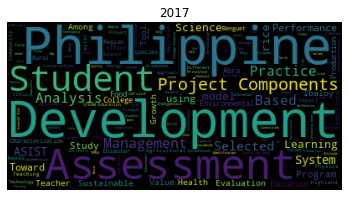

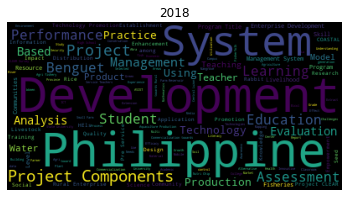

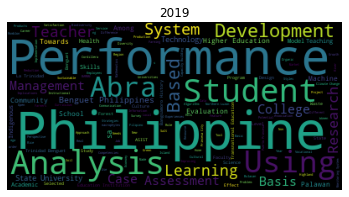

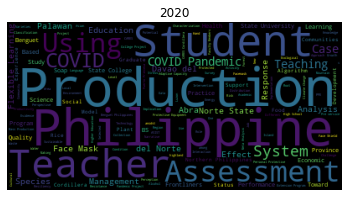

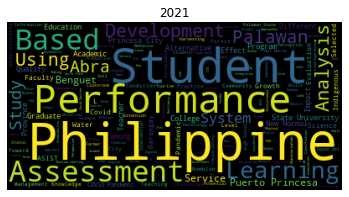

In [5]:
for year in range(2017, 2022):
    wc_year = res_prop[res_prop['Year (YYYY)'] == year]
    try:
        wordcloud = (WordCloud().generate(
            ' '.join(wc_year['Research Title'].dropna())))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(year)
        plt.show()
    except:
        pass

In [3]:
def filter_words(s):
    """ remove unnecessary words that do not give meaning to research title
    
    Parameters
    ----------
    s         :   pandas.Series
                  column to filter words
    
    Returns
    ----------
    filter_words  :   pandas.Series
                      cleaned words
    """
    # tokenize
    tokenize = s.apply(nltk.word_tokenize)

    # casefold
    lower_case = tokenize.apply(lambda x:
                                list(map(lambda y: y.casefold(), x)))


    # lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatize = lower_case.apply(lambda x: list(map(lemmatizer.lemmatize,
                                                             x)))

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_stopwords = lemmatize.apply(lambda x:
                                          list(filter(lambda y: y
                                                      not in 
                                                      stop_words,
                                                      x)))

    # filter words with less than 3 character length
    filtered_words = filtered_stopwords.apply(lambda x:
                                               list(filter(lambda y:
                                                           len(y) > 3,
                                                           x)))
    
    # filter common words
    common_words = ['philippine', 'development', 'study', 'research', 
                   'used', 'based', 'student', 'teacher', 'using']
    filtered_words = filtered_words.apply(lambda x:
                                           list(filter(lambda y: y
                                                       not in 
                                                       common_words,
                                                       x)))

    return filtered_words.apply(lambda x: ' '.join(x))

In [7]:
res_prop['Research Title_clean'] = filter_words(res_prop['Research Title'])

### Overall

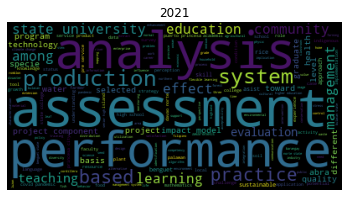

In [8]:
wordcloud = (WordCloud().generate(
    ' '.join(res_prop['Research Title_clean'].dropna())))
plt.imshow(wordcloud)
plt.axis("off")
plt.title(year)
plt.show()

### Yearly Research Titles

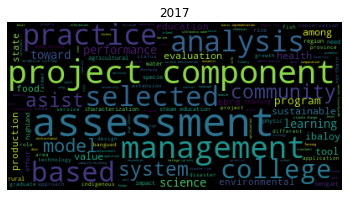

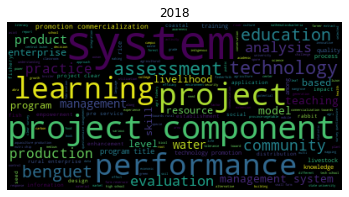

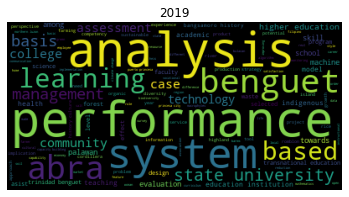

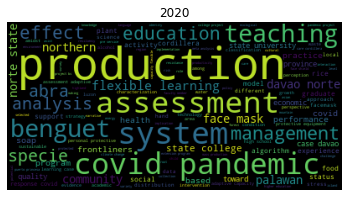

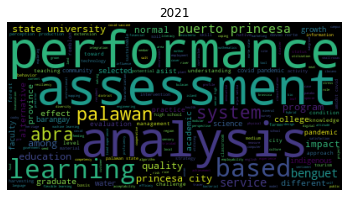

In [9]:
for year in range(2017, 2022):
    wc_year = res_prop[res_prop['Year (YYYY)'] == year]
    try:
        wordcloud = (WordCloud().generate(
            ' '.join(wc_year['Research Title_clean'].dropna())))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(year)
        plt.show()
    except:
        pass

In [58]:
# initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b[a-z]+\b', 
                                   ngram_range=(1, 2),
                                   max_df=0.8,
                                   min_df=0.01)

# get bag of words representation
bow_title_all = dict()
for year in range(2017, 2022):
    wc_year = res_prop[res_prop['Year (YYYY)'] == year]
    clean_title = 'Research Title_clean'
    bow_title = tfidf_vectorizer.fit_transform(wc_year[clean_title])
    df_bow = pd.DataFrame.sparse.from_spmatrix(
                bow_title, columns=tfidf_vectorizer.get_feature_names_out())

    bow_title_all[year] = df_bow

In [4]:
def truncated_svd(X, n_components):
    """ Get the singular vectors and values of the design matrix
    Parameters
    ----------
    X         :  numpy.ndarray
                 design matrix
    Returns
    -------
    X_new             :  numpy.ndarray
                         truncated SVD
    nssd              :  numpy.ndarray
                         normalized sum of square distance from the origin
    """
    # initialize svd
    svd = TruncatedSVD(n_components=n_components, random_state=0)
    X_new = svd.fit_transform(X)
    p = svd.components_.T
    nssd = svd.explained_variance_ratio_.cumsum()

    return X_new, p, nssd





In [ ]:
# loop thru all the selected categories
lsa = dict()
for year, bow in bow_title_all.items():
    X_new, p, nssd = truncated_svd(bow.to_numpy(), bow.shape[1] - 1)
    lsa[year] = {'X_new': X_new,
                 'p': p,
                 'nssd': nssd}

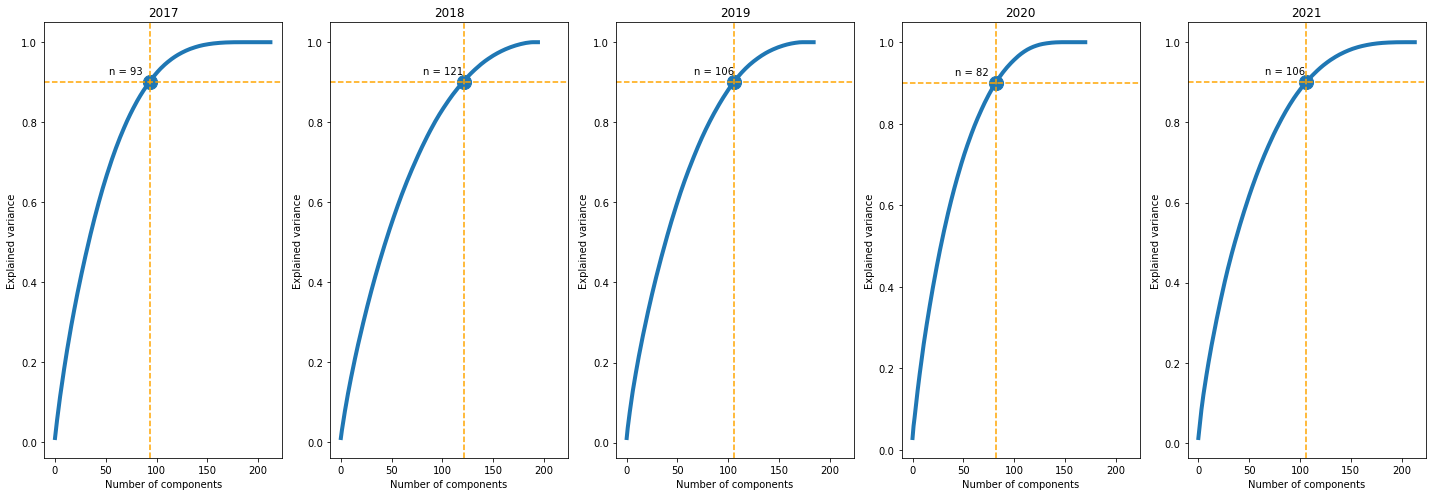

In [64]:
fig, axes = plt.subplots(1, 5, figsize=(20, 7), sharex=True)

for idx, year in enumerate(range(2017, 2022)):
    axes[idx].plot(lsa[year]['nssd'], lw=4)
    axes[idx].set_title(year)
    axes[idx].set_xlabel('Number of components')
    axes[idx].set_ylabel('Explained variance')
    axes[idx].axhline(0.9, ls='--', color='orange')
    # line on threshold
    thresh = (lsa[year]['nssd'] >= 0.9).argmax()
    axes[idx].axvline(thresh, ls='--', color='orange')
    
    # plot a point with text for better readability
    axes[idx].text(thresh - 40, 0.92, f'n = {thresh}')
    axes[idx].scatter(thresh, 0.9, s=200)

fig.tight_layout()
plt.show()
    

In [11]:
def plot_lsa(x, p, feat_names, title):
    """ Plots the reults of LSA
    Plots the following:
    axes[0]    :   scatter plots of first two singular vectors (SVs)
    axes[1]    :   Arrows with feature names that represents the weights 
                   of first two singular vectors (SVs)
    axes[2]    :   Bar plot of the first singular vector
    axes[3]    :   Bar plot of the second singular vector

    Parameters
    ----------
    x          :   numpy.ndarray
                   X_new from SVD 
    p          :   numpy.ndarray
                   principal components
    feat_names :   list 
                   feature names from the columns of BoW representation 
                   of our dataset
    """
    fig, axes = plt.subplots(1, 1)
    norm = ((p[:, 0] - p[:, 1])**2)
    ind = np.argsort(norm, axis=0)[-15:]
    for feature, vec in zip(feat_names.columns[ind], p[ind]):
        axes.arrow(0, 0, vec[0]*1.5, vec[1]*1.5, width=0.01, ec='none')
        axes.text(vec[0]*1.65, vec[1]*1.65, feature, ha='center',
                  fontsize=12)

    spines = ['right', 'top']
    [axes.spines[spine].set_visible(False) for spine in spines]
    axes.tick_params(axis='both', which='both', length=0)
    axes.set_xlabel('SV1')
    axes.set_ylabel('SV2')
    axes.set_title(title)
    
    fig.tight_layout()

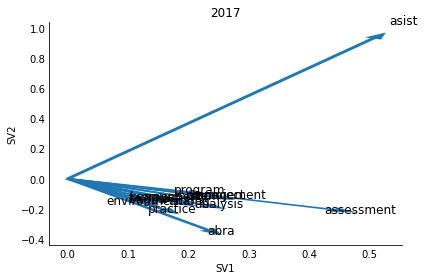

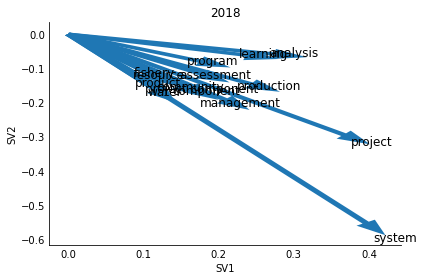

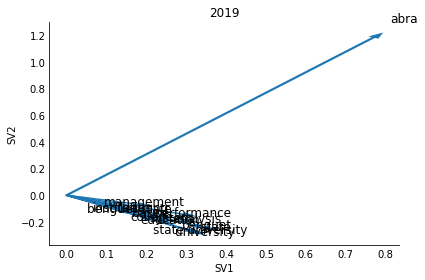

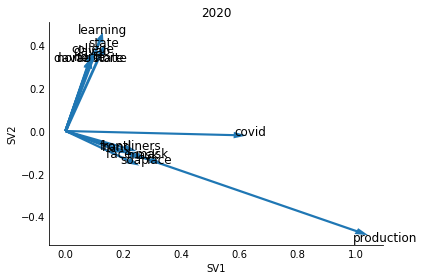

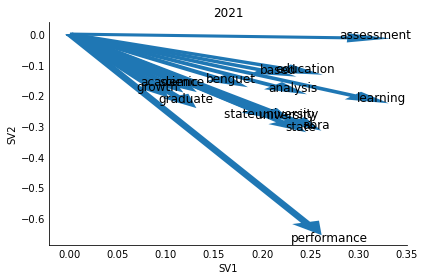

In [62]:
for year in range(2017, 2022):
    x = lsa[year]['X_new']
    p = lsa[year]['p']
    feat_names = bow_title_all[year]
    title = f'{year}'
    plot_lsa(x, p, feat_names, title)

## Author

Summary: 
- Most of the authors published only one research paper in their whole stay
- There are a number of co-authors to explore further for network analysis

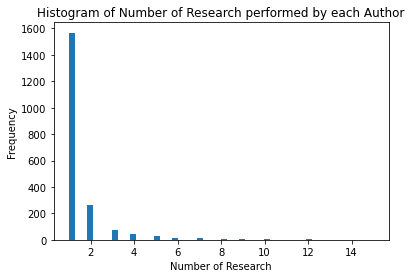

In [34]:
authors = res_prop.Author.str.split(';').explode()
# remove empty string
authors = authors[authors != '']
# plot histogram
auth_vals = authors.value_counts()
auth_vals.plot.hist(bins=50)
plt.title('Histogram of Number of Research performed by each Author')
plt.xlabel('Number of Research');

In [73]:
print('Print Statistics:')
display(authors.value_counts().describe())
print(f'''Author with most research entry ({authors.value_counts().max()}): 
         {authors.value_counts().idxmax()}''')

Print Statistics:


count    2028.000000
mean        1.500986
std         1.346852
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: Author, dtype: float64

Author with most research entry (15): 
         Napadlet, Jones T.


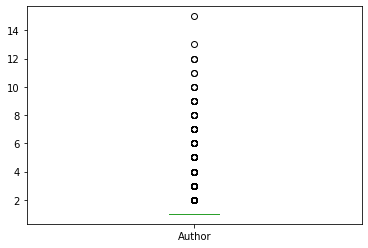

In [74]:
authors.value_counts().plot.box();

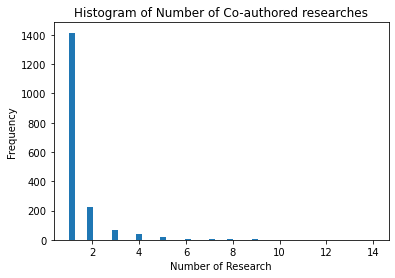

In [35]:
coauthor = res_prop.Author.str.split(';').apply(lambda x: [i for i in x if i])
coauthor = pd.DataFrame(coauthor)
coauthor['length'] = coauthor['Author'].str.len()
coauthor = coauthor[coauthor['length'] > 1]['Author']


co_auth_counts = coauthor.explode().value_counts()
co_auth_counts.plot.hist(bins=50)
plt.title('Histogram of Number of Co-authored researches')
plt.xlabel('Number of Research');

In [76]:
print(f'Number of research with coauthors: {len(coauthor)}')

Number of research with coauthors: 719


In [77]:
def most_lift():
    """ 10 association rules with most lift 
    
    Returns
    =======
    most_lift    : list
                   list of tuples of consequent, antecent, and lift
    """
    df = pd.read_excel('pos_data.xlsx')
    db = df.groupby('BILL_ID')['ITEM_ID'].apply(set).to_list()
    out = fim.eclat(db, supp=1, conf=60, report='l', eval='l', target='r')
    out = sorted(out, key=lambda x: (-x[2], x[0], len(x[1])))
    return [(tuple(sorted(i[1])), i[0]) for i in out[:10]]

In [78]:
# Frequent itemset mining
coauthor = res_prop.Author.str.split(';').apply(lambda x: [i for i in x if i])
db = coauthor.apply(set).to_list()
fim_res = fim.apriori(db, supp=-3, zmin=2)

df_coauthor = pd.DataFrame(sorted(fim_res, key=lambda x: (-x[1], len(x[0]))), 
                           columns=['authors', 'count'])

display(df_coauthor)

,authors,count
0,"(Buot Jr., Inocencio E., Napadlet, Jones T.)",7
1,"(Lumbres, Roscinto Ian C., Doyog, Nova D.)",7
2,"(Doyog, Nova D., Lee, Young Jin)",7
3,"(Walitang, Denver I., Sa, Tongmin)",5
4,"(Flores, Josefina A., Talledo, Maria Rebecca B.)",4
5,"(Backian, Grace S., Meldoz, Dalen T.)",4
6,"(Edullantes, Christine Mae A., Gumanao, Girley...",4
7,"(Lagura, Glenne B., Decano, Ronald S.)",4
8,"(Lumbres, Roscinto Ian C., Lee, Young Jin)",4
9,"(Lumbres, Roscinto Ian C., Doyog, Nova D., Lee...",4


In [86]:
# Association pattern mining
out = fim.eclat(db, supp=-10, conf=30, report='l', eval='l', target='r')
df_coauthor = pd.DataFrame(sorted(out, key=lambda x: (-x[2], len(x[0]))), 
                           columns=['consequent', 'antecedent', 'lift'])

display(df_coauthor)

,consequent,antecedent,lift
0,"Lumbres, Roscinto Ian C.","(Doyog, Nova D.,)",110.600000
1,"Flores, Josefina A.","(Talledo, Maria Rebecca B.,)",105.333333
2,"Lee, Young Jin","(Doyog, Nova D.,)",98.311111
3,"Buot Jr., Inocencio E.","(Napadlet, Jones T.,)",84.266667


## Keywords

Summary: 
- Only 36% of the research topics have keywords attached to it; might be better not to use it

In [80]:
pct_present = 1 - len(res_prop.Keywords.dropna())/len(res_prop.Keywords)
print(f'Percentage of research papers with keywords: {pct_present * 100}')

Percentage of research papers with keywords: 36.7879746835443


## Abstract

Summary: 
- Only 42% of the research topics have abstract attached to it
- Focus on data-driven research
- Emergence of COVID-19 pandemic research in 2020

In [3]:
pct_present = 1 - len(res_prop.Abstract.dropna())/len(res_prop.Abstract)
print(f'Percentage of research papers with abstract: {pct_present * 100}')

Percentage of research papers with abstract: 41.45569620253164


In [5]:
res_prop['Abstract_clean'] = filter_words(res_prop['Abstract'].dropna())

### Overall

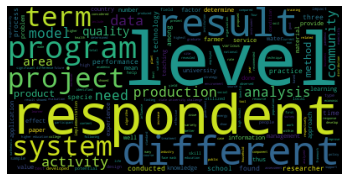

In [6]:
wordcloud = (WordCloud().generate(
    ' '.join(res_prop['Abstract_clean'].dropna())))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Yearly Abstract text

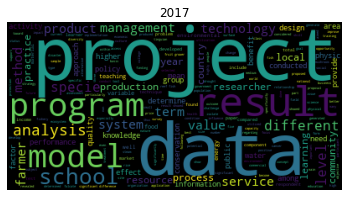

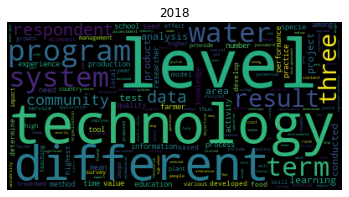

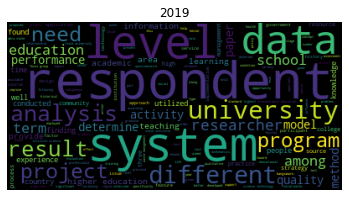

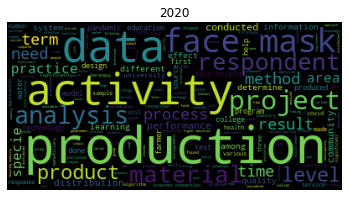

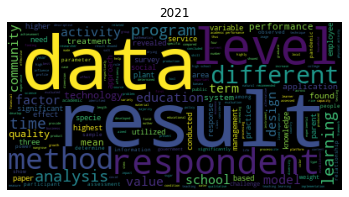

In [7]:
for year in range(2017, 2022):
    wc_year = res_prop[res_prop['Year (YYYY)'] == year]
    try:
        wordcloud = (WordCloud().generate(
            ' '.join(wc_year['Abstract_clean'].dropna())))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(year)
        plt.show()
    except:
        pass

In [8]:
# initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\b[a-z]+\b', 
                                   ngram_range=(1, 2),
                                   max_df=0.8,
                                   min_df=0.01)

# get bag of words representation
bow_abstract_all = dict()
for year in range(2017, 2022):
    wc_year = res_prop[res_prop['Year (YYYY)'] == year]
    clean_abs = 'Abstract_clean'
    bow_abstract = tfidf_vectorizer.fit_transform(wc_year[clean_abs].dropna())
    df_bow = pd.DataFrame.sparse.from_spmatrix(
                bow_abstract, 
                columns=tfidf_vectorizer.get_feature_names_out())

    bow_abstract_all[year] = df_bow

In [9]:
# loop thru all the selected categories
lsa_abs = dict()
for year, bow in tqdm(bow_abstract_all.items()):
    X_new, p, nssd = truncated_svd(bow.to_numpy(), 2)
    lsa_abs[year] = {'X_new': X_new,
                     'p': p,
                     'nssd': nssd}


100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


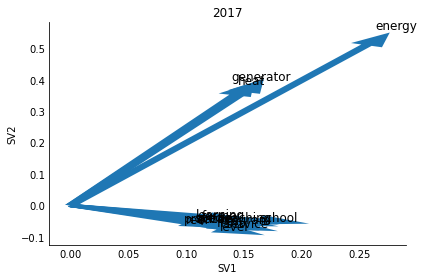

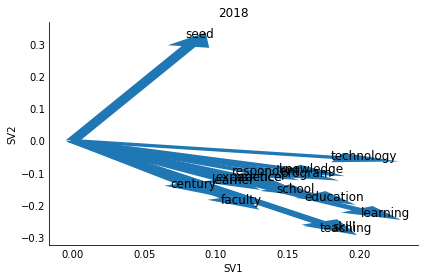

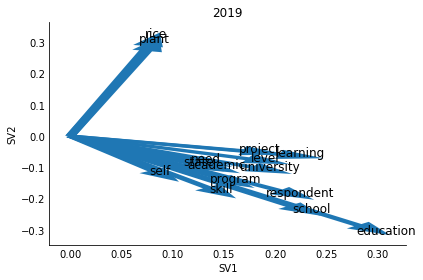

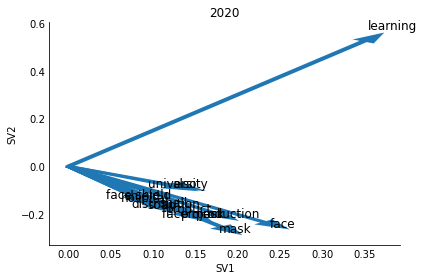

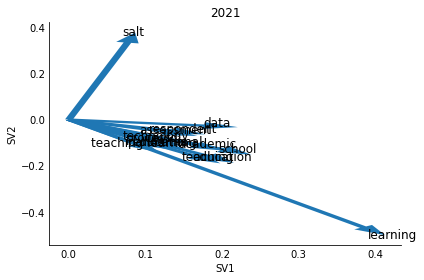

In [12]:
for year in range(2017, 2022):
    x = lsa_abs[year]['X_new']
    p = lsa_abs[year]['p']
    feat_names = bow_abstract_all[year]
    title = f'{year}'
    plot_lsa(x, p, feat_names, title)

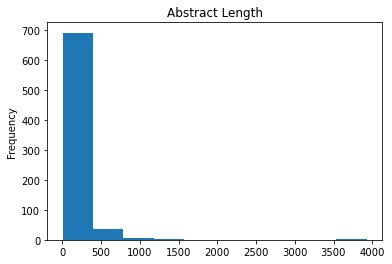

In [69]:
res_prop['Abstract'].dropna().str.split().str.len().plot.hist()
plt.title('Abstract Length');

References http://www.scholarpedia.org/article/Latent_semantic_analysis#:~:text=Latent%20semantic%20analysis%20(LSA)%20is,human%20language%20learning%20and%20understanding.